# Long-Short Strategy, Part 1: Preparing Alpha Factors and Features

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. `preparing_the_model_data` (this noteboook): we'll engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2000-01-01'
END = '2024-01-01'

In [5]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [6]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]

In [7]:
T = [1, 5, 10, 21, 42, 63]

## Loading Quandl Wiki Stock Prices & Meta Data

In [8]:
DATA_STORE = './data/assets.h5'
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['merval/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .swaplevel()
              .sort_index())
    metadata = (store['merval/stocks'].loc[:, ['marketcap', 'sector']])

In [9]:
prices.volume /= 1e3 # make vol figures a bit smaller
prices.index.names = ['symbol', 'date']
metadata.index.name = 'symbol'

## Remove stocks with insufficient observations

We require at least 7 years of data; we simplify and select using both in- and out-of-sample period; please be aware that it would be more accurate to use only the training period to remove data to avoid lookahead bias.

In [10]:
min_obs = 7 * YEAR
nobs = prices.groupby(level='symbol').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

### Align price and meta data

In [11]:
metadata = metadata[~metadata.index.duplicated() & metadata.sector.notnull()]
metadata.sector = metadata.sector.str.lower().str.replace(' ', '_')

In [12]:
shared = (prices.index.get_level_values('symbol').unique()
          .intersection(metadata.index))
metadata = metadata.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

### Rank assets by Rolling Average Dollar Volume

#### Compute dollar volume

In [13]:
prices['dollar_vol'] = prices[['close', 'volume']].prod(1).div(1e3)

#### 21-day moving average

In [14]:
# compute dollar volume to determine universe
dollar_vol_ma = (prices
                 .dollar_vol
                 .unstack('symbol')
                 .rolling(window=21, min_periods=1) # 1 trading month
                 .mean())

#### Rank stocks by moving average

In [15]:
prices['dollar_vol_rank'] = (dollar_vol_ma
                            .rank(axis=1, ascending=False)
                            .stack('symbol')
                            .swaplevel())

In [16]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 294529 entries, ('ALUA.BA', Timestamp('2002-07-22 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             294529 non-null  float64
 1   close            294529 non-null  float64
 2   low              294529 non-null  float64
 3   high             294529 non-null  float64
 4   volume           294529 non-null  float64
 5   dollar_vol       294529 non-null  float64
 6   dollar_vol_rank  294529 non-null  float64
dtypes: float64(7)
memory usage: 16.7+ MB


## Add some Basic Factors

See [appendix](../24_alpha_factor_library) for details on the below indicators.

### Compute the Relative Strength Index

In [17]:
rsi = prices.groupby(level='symbol').close.apply(RSI)
prices['rsi'] = rsi.values

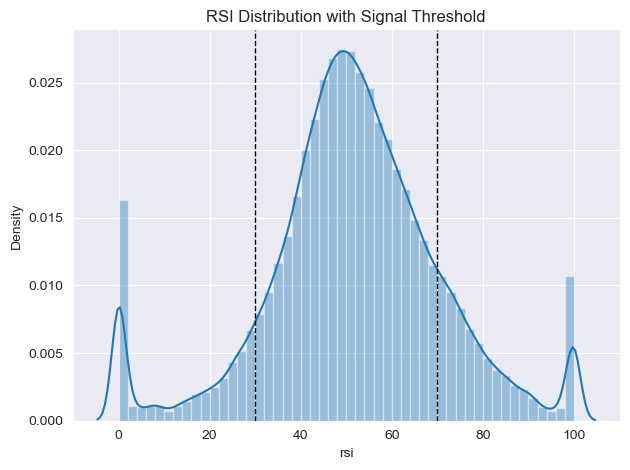

In [18]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

### Compute Bollinger Bands

In [19]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [20]:
bb = prices.groupby(level='symbol').close.apply(compute_bb)

prices['bb_high'] = bb['bb_high'].values
prices['bb_low'] = bb['bb_low'].values


In [21]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

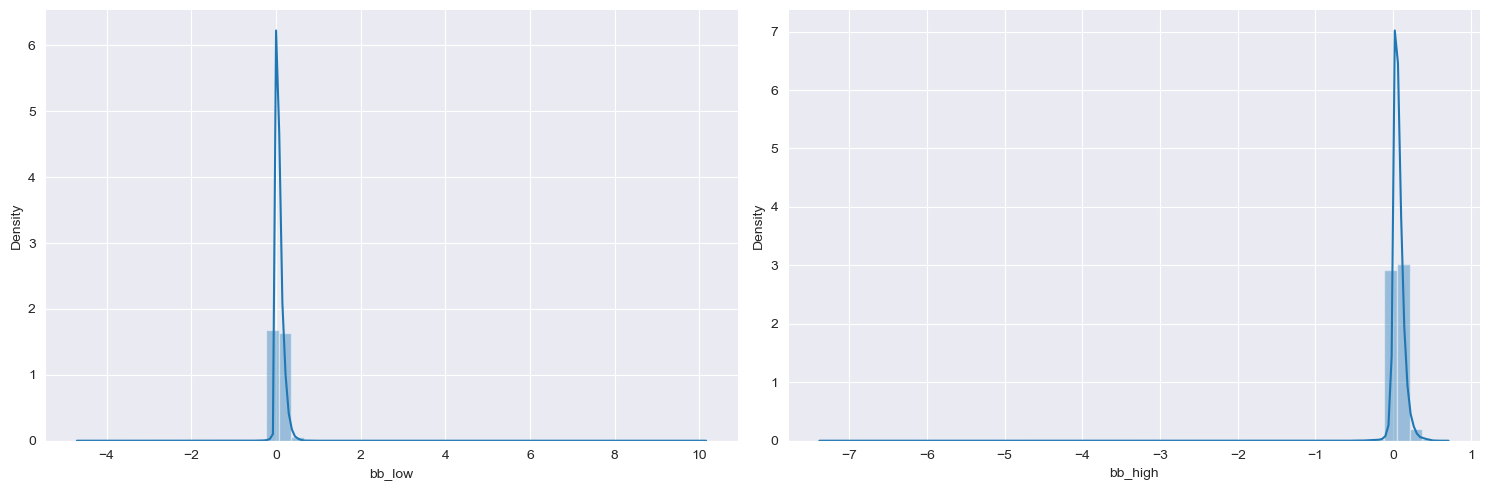

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();

### Compute Average True Range

In [23]:
prices['NATR'] = prices.groupby(level='symbol', 
                                group_keys=False).apply(lambda x: 
                                                        talib.NATR(x.high, x.low, x.close))

In [24]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [25]:
prices['ATR'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_atr))

### Compute Moving Average Convergence/Divergence

In [26]:
by_ticker = prices.groupby('symbol', group_keys=False)
prices['ppo'] = by_ticker.close.apply(talib.PPO)

In [27]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [28]:
prices['MACD'] = (prices
                  .groupby('symbol', group_keys=False)
                  .close
                  .apply(compute_macd))

### Combine Price and Meta Data

In [29]:
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

## Compute Returns

### Historical Returns

In [30]:
by_sym = prices.groupby(level='symbol').close
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

### Daily historical return deciles

In [31]:
t = 1
def qcut(x):
	return pd.qcut(x, q=10, labels=False, duplicates='drop')
    
prices[f'r{t:02}'].groupby(level='symbol').apply(lambda x: x.iloc[1:]).groupby(level='date').apply(qcut).values

array([1., 3., 0., ..., 7., 2., 8.])

In [32]:
prices[f'r{t:02}'].info()

<class 'pandas.core.series.Series'>
MultiIndex: 294529 entries, ('ALUA.BA', Timestamp('2002-07-22 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Series name: r01
Non-Null Count   Dtype  
--------------   -----  
294474 non-null  float64
dtypes: float64(1)
memory usage: 3.3+ MB


### Compute Forward Returns

In [33]:
for t in [1, 5, 21]:
    prices[f'r{t:02}_fwd'] = prices.groupby(level='symbol')[f'r{t:02}'].shift(-t)

## Remove outliers

In [34]:
prices[[f'r{t:02}' for t in T]].describe()

,r01,r05,r10,r21,r42,r63
count,294474.000000,294254.000000,293979.000000,293374.000000,292219.000000,291064.000000
mean,0.001923,0.009299,0.018537,0.039465,0.079774,0.121104
std,0.047477,0.097733,0.135257,0.201673,0.306935,0.394992
min,-2.199139,-2.485659,-2.436919,-2.535598,-2.665221,-2.836180
25%,-0.009524,-0.026344,-0.037037,-0.052174,-0.066667,-0.075056
50%,0.000000,0.000000,0.000000,0.000000,0.020619,0.041096
75%,0.010929,0.034884,0.057143,0.098886,0.169591,0.241980
max,9.333334,9.689655,10.341463,9.689655,15.000000,15.000000


We remove daily returns above 100 percent as these are more likely to represent data errors; we are using the 100 percent cutoff here in a somewhat ad-hoc fashion; you would want to apply more careful exploratory and historical analysis to decide which assets are truly not representative of the sample period.

In [35]:
outliers = prices[prices.r01 > 1].index.get_level_values('symbol').unique()

In [36]:
prices = prices.drop(outliers, level='symbol')

## Create time and sector dummy variables

In [37]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday

## Store Model Data

In [38]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 213116 entries, ('ALUA.BA', Timestamp('2002-07-22 00:00:00')) to ('VALO.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             213116 non-null  float64
 1   close            213116 non-null  float64
 2   low              213116 non-null  float64
 3   high             213116 non-null  float64
 4   volume           213116 non-null  float64
 5   dollar_vol       213116 non-null  float64
 6   dollar_vol_rank  213116 non-null  float64
 7   rsi              212570 non-null  float64
 8   bb_high          212375 non-null  float64
 9   bb_low           212373 non-null  float64
 10  NATR             212570 non-null  float64
 11  ATR              212570 non-null  float64
 12  ppo              212141 non-null  float64
 13  MACD             211829 non-null  float64
 14  sector           213116 non-null  int64  
 15  r0

In [39]:
prices.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).to_hdf('data.h5', 'model_data')